In [1]:
# Import libraries and dependencies
import os
import pandas as pd
from pathlib import Path
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [4]:
def days_to_trading_days(days):
    return round(days * 252 / 365)

def trading_days_to_days(trading_days):
    return round(trading_days * 365 / 252)

In [5]:
def get_barset_amzn(start_date, end_date):
    """
    Gets alpaca barset for AMZN with 1D timeframe for the given dates
    and returns the data in a pandas dataframe.
    
    If the num of days is greater than 1000, it makes more than one api
    call and combines the responses in a single dataframe.
    """
    # Initialize a variable `df` to store the final dataframe.
    df = None;
    
    # Calculate the num of days in the given start and end dates
    days = (end_date - start_date).days
    
    # Convert num of days into num of trading days
    trading_days = days_to_trading_days(days)
    
    # Calculate the num of calls to make
    # e.g. for 1500 trading days we need to make at least 2 api calls
    # trading_days = 1500, round(trading_days/1000) = 1, num_api_calls = 1 + 1 = 2
    num_api_calls = 1 + round(trading_days/1000)
    
    # 252 trading days = 365 normal days
    # 1000 trading days = 1000 * 365 / 252 normal days
    days_per_1k_trading_days = trading_days_to_days(1000)
    
    start = start_date 
    for i in range(num_api_calls):
        end = start + pd.DateOffset(days_per_1k_trading_days)
        print(str(start)+" to "+str(end))
        tmp_df = api.get_barset(
            "AMZN",
            "1D",
            start = start.isoformat(),
            end = end.isoformat() ,
            limit = 1000
        ).df
        start = end       
        if df is None:
            df = tmp_df
        else:
            df = pd.concat([df, tmp_df])
                   
    return df

In [6]:
start_date = pd.Timestamp("2016-01-01", tz="America/New_York")
end_date = pd.Timestamp("2021-04-08", tz="America/New_York")
df = get_barset_amzn(start_date, end_date)

2016-01-01 00:00:00-05:00 to 2019-12-19 00:00:00-05:00
2019-12-19 00:00:00-05:00 to 2023-12-06 00:00:00-05:00


In [7]:
(end_date - start_date).days

1923

In [8]:
df.shape[0]

1327

In [9]:
df

AMZN                                      
                              open       high      low    close   volume
time                                                                    
2016-01-04 00:00:00-05:00   656.29   657.7150   627.51   636.73  6683946
2016-01-05 00:00:00-05:00   646.86   646.9100   627.65   633.79  4288182
2016-01-06 00:00:00-05:00   622.00   639.7900   620.31   632.81  3865144
2016-01-07 00:00:00-05:00   622.38   630.0000   605.21   607.84  5235612
2016-01-08 00:00:00-05:00   618.86   624.1400   606.00   607.23  4005059
...                            ...        ...      ...      ...      ...
2021-04-05 00:00:00-04:00  3173.50  3235.9550  3161.24  3225.26  2813107
2021-04-06 00:00:00-04:00  3223.75  3247.3100  3217.04  3223.99  2095298
2021-04-07 00:00:00-04:00  3230.38  3303.6125  3223.65  3279.39  3072199
2021-04-08 00:00:00-04:00  3309.14  3324.5000  3292.00  3299.99  2543206
2021-04-09 00:00:00-04:00  3303.01  3372.0900  3288.90  3372.09  3934619

[1327 rows x 5 columns]

In [10]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
MC_AMZN = MCSimulation(
    portfolio_data = df,
    weights = [1],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [11]:
# Printing the simulation input data
MC_AMZN.portfolio_data

AMZN                                        \
                              open       high      low    close   volume   
time                                                                       
2016-01-04 00:00:00-05:00   656.29   657.7150   627.51   636.73  6683946   
2016-01-05 00:00:00-05:00   646.86   646.9100   627.65   633.79  4288182   
2016-01-06 00:00:00-05:00   622.00   639.7900   620.31   632.81  3865144   
2016-01-07 00:00:00-05:00   622.38   630.0000   605.21   607.84  5235612   
2016-01-08 00:00:00-05:00   618.86   624.1400   606.00   607.23  4005059   
...                            ...        ...      ...      ...      ...   
2021-04-05 00:00:00-04:00  3173.50  3235.9550  3161.24  3225.26  2813107   
2021-04-06 00:00:00-04:00  3223.75  3247.3100  3217.04  3223.99  2095298   
2021-04-07 00:00:00-04:00  3230.38  3303.6125  3223.65  3279.39  3072199   
2021-04-08 00:00:00-04:00  3309.14  3324.5000  3292.00  3299.99  2543206   
2021-04-09 00:00:00-04:00  3303.01  3372.0900  3288.90  3372.09  3934619   

                                        
                          daily_return  
time                                    
2016-01-04 00:00:00-05:00          NaN  
2016-01-05 00:00:00-05:00    -0.004617  
2016-01-06 00:00:00-05:00    -0.001546  
2016-01-07 00:00:00-05:00    -0.039459  
2016-01-08 00:00:00-05:00    -0.001004  
...                                ...  
2021-04-05 00:00:00-04:00     0.020152  
2021-04-06 00:00:00-04:00    -0.000394  
2021-04-07 00:00:00-04:00     0.017184  
2021-04-08 00:00:00-04:00     0.006282  
2021-04-09 00:00:00-04:00     0.021849  

[1329 rows x 6 columns]

In [12]:
# Run Monte Carlo simulations to forecast five years daily returns
MC_AMZN.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.988802,0.983624,0.958127,1.021442,1.015439,0.999422,0.975554,1.037786,0.997338,0.978100,...,0.980255,0.996117,0.988192,0.990872,1.028761,0.984146,0.993011,1.026827,0.993315,0.998097
2,0.950090,1.038037,0.964530,0.985808,1.050858,0.974430,0.950925,1.016258,0.977226,1.005889,...,0.987316,1.004726,0.996709,0.989669,1.044378,0.983286,1.003523,1.007423,1.010101,1.018293
3,0.950244,1.050074,0.971613,0.997777,1.045505,0.975750,0.953974,1.024063,0.984713,1.000717,...,0.953072,1.003790,1.024738,1.007334,1.039360,0.981850,0.987979,1.004350,1.028773,1.012029
4,0.922901,1.049514,0.934503,0.964929,1.040012,0.962534,0.941923,1.018548,0.978793,1.020330,...,0.939920,0.989457,1.006994,1.007040,1.013253,0.999843,1.009770,1.010483,1.026908,1.010985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,3.430109,8.456962,1.633144,4.631444,3.244364,3.225180,1.200122,9.961111,7.760036,5.472334,...,17.758790,3.433715,8.800492,1.541367,3.238901,3.219160,4.449508,13.803977,2.804561,2.808736
1257,3.390605,8.820451,1.591816,4.647321,3.181132,3.245833,1.199927,9.892394,7.659430,5.374880,...,18.229001,3.423470,8.836719,1.553377,3.292227,3.229950,4.484918,13.813821,2.794582,2.714707
1258,3.472355,8.938004,1.630562,4.731242,3.118321,3.253454,1.180527,9.839257,7.387685,5.484602,...,18.445196,3.370296,8.967175,1.497050,3.366161,3.127160,4.486249,13.704884,2.792089,2.731501
1259,3.431803,9.097226,1.625009,4.681480,3.052968,3.313517,1.161832,9.911440,7.595253,5.447238,...,17.665016,3.389081,9.013033,1.496441,3.367287,3.133205,4.392090,13.160022,2.812106,2.713935


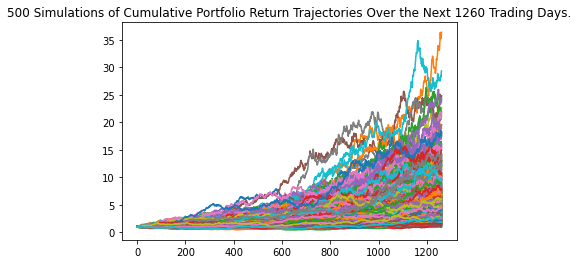

In [13]:
# Plot simulation outcomes
line_plot = MC_AMZN.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("MC_fiveyear_sim_plot.png", bbox_inches="tight")

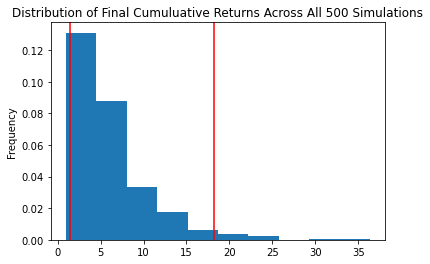

In [14]:
# Plot probability distribution and confidence intervals
dist_plot = MC_AMZN.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_fiveyear_dist_plot.png',bbox_inches='tight')

In [15]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_AMZN.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              6.138888
std               4.517247
min               0.954847
25%               3.120379
50%               4.881669
75%               7.733144
max              36.374409
95% CI Lower      1.462899
95% CI Upper     18.145380
Name: 1260, dtype: float64


In [16]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments in AMZN stocks
ci_lower = round(tbl[8]*10000,2)
ci_upper = round(tbl[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next year will end within in the range of"
      f" ${ci_lower} and ${ci_upper}.")

There is a 95% chance that an initial investment of $15,000 in the portfolio over the next year will end within in the range of $14628.99 and $181453.8.


In [17]:
# Compute summary statistics from the simulated daily returns
simulated_returns_data = {
    'mean' : list(MC_AMZN.simulated_return.mean(axis=1)),
    'median' : list(MC_AMZN.simulated_return.median(axis=1)),
    'min' : list(MC_AMZN.simulated_return.min(axis=1)),
    'max' : list(MC_AMZN.simulated_return.max(axis=1))
}

# Create a DataFrame with the summary statistics
df_simulated_returns = pd.DataFrame(simulated_returns_data)

# Display sample data
df_simulated_returns.head()

,mean,median,min,max
0,1.000000,1.000000,1.000000,1.000000
1,1.001359,1.001191,0.943825,1.059617
2,1.002477,1.002273,0.922209,1.085034
3,1.004659,1.005374,0.897506,1.094901
4,1.006193,1.007091,0.890042,1.113595


<AxesSubplot:title={'center':'Simulated Daily Returns Behavior of AMZN Stock Over the Next Year'}>

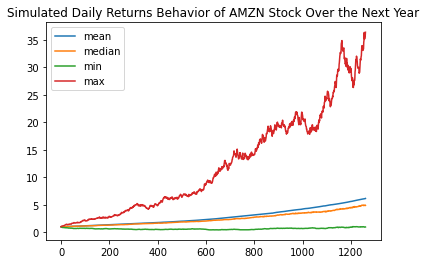

In [18]:
# Use the `plot` function to visually analyze the trajectory of AMZN stock daily returns on a trading day simulation
df_simulated_returns.plot(title="Simulated Daily Returns Behavior of AMZN Stock Over the Next Year")

In [19]:
# Set initial investment
initial_investment = 15000

# Multiply an initial investment by the daily returns of simulative stock prices to return the progression of daily returns in terms of money
cumulative_pnl = initial_investment * df_simulated_returns

# Display sample data
cumulative_pnl.head()

,mean,median,min,max
0,15000.000000,15000.000000,15000.000000,15000.000000
1,15020.384971,15017.870014,14157.371123,15894.249932
2,15037.150250,15034.102074,13833.133464,16275.512118
3,15069.889094,15080.615284,13462.584402,16423.511049
4,15092.901758,15106.362631,13350.626361,16703.923923


<AxesSubplot:title={'center':'Simulated Outcomes Behavior of AMZN Stock Over the Next Year'}>

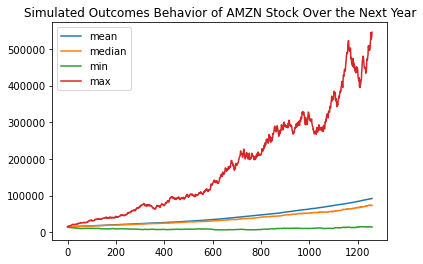

In [20]:
# Use the 'plot' function to create a chart of the simulated profits/losses
cumulative_pnl.plot(title="Simulated Outcomes Behavior of AMZN Stock Over the Next Year")